# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

_Note_:
- The notebook will run using the results stored in the `output` folder. They were generated using the following:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_reduced_duplication --aug-strategy-test augmentation_with_reduced_duplication --aug-nb-train 70 --aug-nb-test 70 --ml-model CONV1D --eval-strategy True
```
- a `figures` folder will be created in which the images are saved.

📝 Have a look at the [README](https://github.com/volkamerlab/maxsmi/blob/main/README.md) page for more details.

## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- the absolute error between the true value and the average value
- confidence of the prediction: is the standard deviation low or high?

This data represents _only_ the test set (20%) and not the full data (100%).

### Goal
The aim of this notebook is to look at the best models which use duplication of SMILES (with and with reduced) in training and testing and analyse whether a model could learn inherent symmetry of compounds.

In [1]:
import os
import pandas as pd
from collections import Counter

from rdkit import Chem
from rdkit.Chem import PandasTools, Draw

from utils_analysis import load_results
from utils_smiles import get_num_heavy_atoms

In [2]:
# Make a folder for output figures
os.makedirs("figures", exist_ok=True)

## Dataset
We consider the following datasets:

- ESOL
- lipophilicity

_Note_: we do not look at the free_solv data, since the best strategy for this task is augmentation without duplication, which is not the focus of this study, but rather augmentation with or with reduced duplication. 

Comment/uncomment the dataset of choice in the cell below.

In [3]:
# TASK = "lipophilicity"
TASK = "ESOL"

## Best models
Retrieve best models for the ESOL and the lipophilicity data sets.

In [4]:
if TASK == "ESOL":
    STRING_ENCODING = "smiles"
    TRAIN_AUGMENTATION = 70
    TEST_AUGMENTATION = 70
    AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_reduced_duplication"
    AUGMENTATION_STRATEGY_TEST = "augmentation_with_reduced_duplication"
    ML_MODEL = "CONV1D"

elif TASK == "lipophilicity":
    STRING_ENCODING = "smiles"
    TRAIN_AUGMENTATION = 80
    TEST_AUGMENTATION = 80
    AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_duplication"
    AUGMENTATION_STRATEGY_TEST = "augmentation_with_duplication"
    ML_MODEL = "CONV1D"

## Load data

In [5]:
test_data = load_results(TASK,
                         AUGMENTATION_STRATEGY_TRAIN,
                         TRAIN_AUGMENTATION,
                         AUGMENTATION_STRATEGY_TEST,
                         TEST_AUGMENTATION,
                         ML_MODEL,
                         STRING_ENCODING,
                         True)
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988
277,-0.60,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972
937,-0.67,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695
444,-5.05,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186


## Load the canonical counterpart

In [6]:
test_data_canonical = load_results(TASK,
                                   "no_augmentation",
                                   0,
                                   "no_augmentation",
                                   0,
                                   ML_MODEL,
                                   STRING_ENCODING,
                                   True)
test_data_canonical.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1],[CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1],-6.255364,0.0
277,-0.60,CCS,[CCS],[CCS],-0.779630,0.0
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[CC(=O)OCC(COC(C)=O)OC(C)=O],[CC(=O)OCC(COC(C)=O)OC(C)=O],0.379165,0.0
937,-0.67,CCC(C)C(C)=O,[CCC(C)C(C)=O],[CCC(C)C(C)=O],-1.765576,0.0
444,-5.05,C=CCCCCCCC,[C=CCCCCCCC],[C=CCCCCCCC],-4.743603,0.0


Merge the tables into one dataframe.

In [7]:
test_data_canonical = test_data_canonical.rename(columns={"average_\
prediction": "canonical_prediction"})

In [8]:
data = pd.concat([test_data, test_data_canonical["canonical_prediction"]],
                 axis=1)
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.255364
277,-0.60,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.779630
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.379165
937,-0.67,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695,-1.765576
444,-5.05,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186,-4.743603


### Size of molecules
Compute the number of heavy atoms in each molecule.

In [9]:
data["num_heavy_atoms"] = data["canonical_\
smiles"].apply(get_num_heavy_atoms)

## Difference in prediction error with and without augmentation

In [10]:
data["average_error"] = (data["target"] - data["average_prediction"]).abs()
data["canonical_error"] = (data["target"] - data["canonical_prediction"]).abs()
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction,num_heavy_atoms,average_error,canonical_error
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.255364,28,2.029941,2.344636
277,-0.60,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.779630,3,0.135204,0.179630
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.379165,15,0.301669,0.979165
937,-0.67,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695,-1.765576,7,0.135345,1.095576
444,-5.05,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186,-4.743603,9,0.127607,0.306397


In [11]:
data["errors_difference"] = (data["average_error"] -
                             data["canonical_error"]).abs()

In [12]:
# data = data[data["average_error"] < data["canonical_error"]]

In [13]:
for index in data.index:
    nb_unique_smiles = len(Counter(data.loc[index]["augmented_smiles"]))
    data.loc[index,
             "nb_unique_smiles"] = nb_unique_smiles

data["nb_unique_smiles"] = data["nb_unique_smiles"].astype("int32")

In [14]:
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction,num_heavy_atoms,average_error,canonical_error,errors_difference,nb_unique_smiles
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.255364,28,2.029941,2.344636,0.314695,69
277,-0.60,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.779630,3,0.135204,0.179630,0.044426,4
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.379165,15,0.301669,0.979165,0.677497,58
937,-0.67,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695,-1.765576,7,0.135345,1.095576,0.960232,35
444,-5.05,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186,-4.743603,9,0.127607,0.306397,0.178790,16


In [15]:
def num_symmetry_classes(smiles):
    """
    Add
    """
    molecule = Chem.MolFromSmiles(smiles)
    num_symmetry_classes = len(set(Chem.CanonicalRankAtoms(molecule, breakTies=False)))
    return num_symmetry_classes

In [16]:
def symmetry_molecule(smiles):
    """
    Add
    """
    molecule = Chem.MolFromSmiles(smiles)
    num_symmetry_classes = len(set(Chem.CanonicalRankAtoms(molecule, breakTies=False)))
    normed = 1-(len(set(Chem.CanonicalRankAtoms(molecule,breakTies=False)))-1)/(molecule.GetNumAtoms()-1)
    # normed = 1 - len(set(Chem.CanonicalRankAtoms(molecule,breakTies=False)))/molecule.GetNumAtoms()
    return normed

In [17]:
data["num_symm_class"] = data["canonical_smiles"].apply(num_symmetry_classes)

In [18]:
data["symmetry"] = data["canonical_smiles"].apply(symmetry_molecule)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

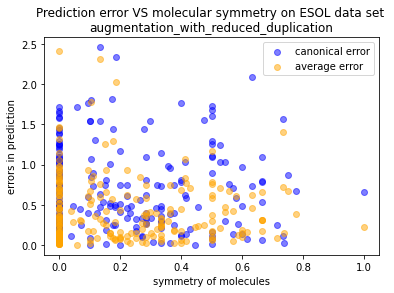

In [20]:
fig, ax = plt.subplots()

x = data["symmetry"]
y = data["canonical_error"]
z = data["average_error"]
# w = data["errors_difference"]

total_min = min(min(x), min(y), min(z))
total_max = max(max(x), max(y), max(z))
plt.scatter(x, y, c="blue", alpha=0.5)
plt.scatter(x, z, c="orange", alpha=0.5)
# plt.scatter(x, w, c="purple", alpha=0.5)


# ax.set_xticks(np.arange(np.floor(total_min), np.ceil(total_max), 1))
# ax.set_yticks(np.arange(np.floor(total_min), np.ceil(total_max), 1))
ax.set_xlabel("symmetry of molecules")
ax.set_ylabel("errors in prediction")
# ax.legend(["canonical error", "average error", "errors_difference"])
ax.legend(["canonical error", "average error"])
# ax.set_aspect("equal", adjustable="box")
ax.set_title(f"Prediction error VS molecular symmetry "
             f"on {TASK} data set \n"
             f"{AUGMENTATION_STRATEGY_TEST}")

plt.show()

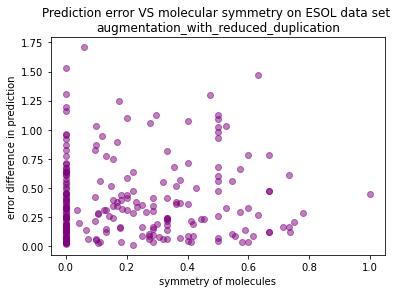

In [21]:
fig, ax = plt.subplots()

x = data["symmetry"]
w = data["errors_difference"]

total_min = min(min(x), min(y), min(z))
total_max = max(max(x), max(y), max(z))

plt.scatter(x, w, c="purple", alpha=0.5)

ax.set_xlabel("symmetry of molecules")
ax.set_ylabel("error difference in prediction")
# ax.legend(["canonical error", "average error", "errors_difference"])
# ax.legend(["canonical error", "average error"])
# ax.set_aspect("equal", adjustable="box")
ax.set_title(f"Prediction error VS molecular symmetry "
             f"on {TASK} data set \n"
             f"{AUGMENTATION_STRATEGY_TEST}")

plt.show()

In [22]:
for index in data.index:
    canonical_smile = data.loc[index]["canonical_smiles"]
    mol = Chem.MolFromSmiles(canonical_smile)
    PandasTools.AddMoleculeColumnToFrame(data,
                                         smilesCol="canonical_smiles")
data = data.rename(columns={"ROMol": "graph"})

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction,num_heavy_atoms,average_error,canonical_error,errors_difference,nb_unique_smiles,num_symm_class,symmetry,graph
181,-8.600,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...","[c1cc(ccc1OCC)C(C)(COCc1cc(ccc1)Oc1ccccc1)C, C...",-6.570059,0.529988,-6.255364,28,2.029941,2.344636,0.314695,69,23,0.185185,
277,-0.600,CCS,"[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...","[C(C)S, C(C)S, C(C)S, C(C)S, SCC, SCC, SCC, SC...",-0.735204,0.098035,-0.779630,3,0.135204,0.179630,0.044426,4,3,0.000000,
125,-0.600,CC(=O)OCC(COC(C)=O)OC(C)=O,"[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...","[C(C(OC(C)=O)COC(C)=O)OC(=O)C, C(C(COC(C)=O)OC...",-0.901669,0.296972,0.379165,15,0.301669,0.979165,0.677497,58,10,0.357143,
937,-0.670,CCC(C)C(C)=O,"[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...","[C(CC)(C)C(C)=O, C(C(=O)C)(C)CC, C(C(=O)C)(C)C...",-0.805345,0.258695,-1.765576,7,0.135345,1.095576,0.960232,35,7,0.000000,
444,-5.050,C=CCCCCCCC,"[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...","[C(CC=C)CCCCC, C(CC=C)CCCCC, C=CCCCCCCC, C=CCC...",-4.922393,0.113186,-4.743603,9,0.127607,0.306397,0.178790,16,9,0.000000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,-0.244,OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O,"[O1C(CO)C(O)C(O)C(O)C1OC1C(OC(O)C(O)C1O)CO, C1...","[O1C(CO)C(O)C(O)C(O)C1OC1C(OC(O)C(O)C1O)CO, C1...",0.662369,0.219136,0.346579,23,0.906369,0.590579,0.315790,70,23,0.000000,
39,-4.810,CCCCCCCI,"[C(CCI)CCCC, C(CCI)CCCC, C(CCI)CCCC, C(I)CCCCC...","[C(CCI)CCCC, C(CCI)CCCC, C(CCI)CCCC, C(I)CCCCC...",-4.739038,0.167620,-4.491160,8,0.070962,0.318840,0.247879,14,8,0.000000,
943,-1.520,c1ccc2[nH]ccc2c1,"[c1c2c([nH]c1)cccc2, c1cc2[nH]ccc2cc1, c1cc2[n...","[c1c2c([nH]c1)cccc2, c1cc2[nH]ccc2cc1, c1cc2[n...",-2.978008,0.319472,-2.780083,9,1.458008,1.260083,0.197926,40,9,0.000000,
512,-2.420,Cc1c[nH]c2ccccc12,"[c12[nH]cc(c2cccc1)C, Cc1c[nH]c2c1cccc2, c1[nH...","[c12[nH]cc(c2cccc1)C, Cc1c[nH]c2c1cccc2, c1[nH...",-3.123561,0.376012,-2.793351,10,0.703561,0.373351,0.330210,44,10,0.000000,

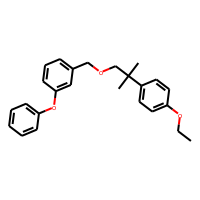
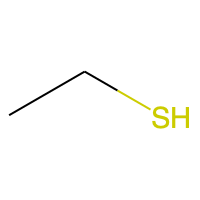
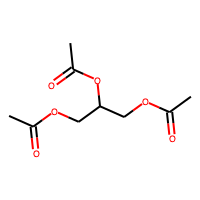
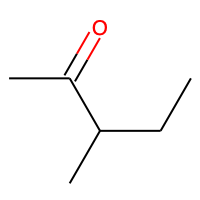
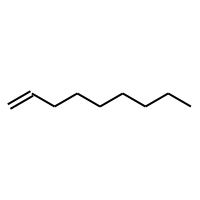
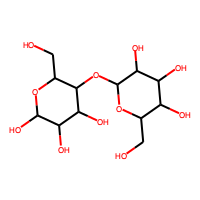
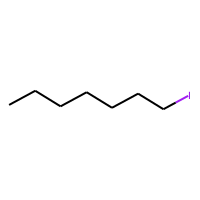
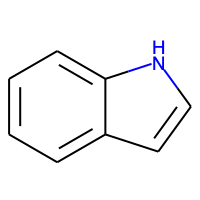
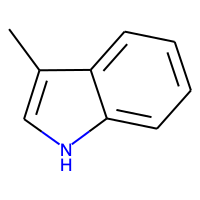
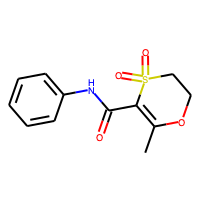

In [23]:
data

In [24]:
# data = data[["average_error", "canonical_error", "symmetry","graph"]]

## Draw molecules

In [25]:
for index in data.index:
    canonical_smile = data.loc[index]["canonical_smiles"]
    mol = Chem.MolFromSmiles(canonical_smile)
    PandasTools.AddMoleculeColumnToFrame(data,
                                         smilesCol="canonical_smiles")
data = data.rename(columns={"ROMol": "graph"})

In [26]:
df = data.style.\
    set_caption(f"Data: {TASK}").\
    format({"target": "{:.2f}",
            "prediction": "{:.2f}",
            "average_prediction": "{:.2f}",
            "std_prediction": "{:.2f}",
            "canonical_error": "{:.2f}",
            "average_error": "{:.2f}",
            "errors_difference": "{:.2f}"})
df

ValueError: style is not supported for non-unique indices.

### Export molecules

In [ ]:
def export_rdkit_images(task):
    """
    Export molecular graph for interesting molecules.
    """
    indices = []
    if task == "ESOL":
        indices = [1063, 971]
    elif task == "lipophilicity":
        indices = [1701]
    for ind in indices:
        canonical_smile = df.data.canonical_smiles[ind]
        molecule = Chem.MolFromSmiles(canonical_smile)
        Draw.MolToFile(molecule, f"figures/{task}_{canonical_smile}.png")

In [ ]:
export_rdkit_images(TASK)